In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:
basetable = pd.read_csv('../../Data/Gold/basetable.csv')

In [79]:
basetable.columns

Index(['datum', 'niveau', 'schepcorner_id', 'ploegnaam', 'ervaring_schepper',
       'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg', 'kwart',
       'is_schepper_bank', 'is_kopper_bank', 'schepper_pos_rechts', 'positie',
       'kop_verplaatsen_achter', 'kop_veel_verplaatsen', 'kop_hor_verplaatsen',
       'goal', 'klassement_thuis', 'klassement_uit', 'uitslag_thuis',
       'uitslag_uit', 'score_voor_thuis', 'score_voor_uit', 'klassement',
       'klassement_veschil', 'is_degradatieplaats', 'is_promotieplaats',
       'score_verschil_voor', 'periode', 'schepcorner_nummer',
       'goal_lag_ploeg', 'goal_lag_wedstrijd'],
      dtype='object')

In [80]:
cols_to_drop = ["datum", "schepcorner_id", "ploegnaam", "klassement_thuis","klassement_uit", "uitslag_uit", "uitslag_thuis"] 
basetable.drop(columns=cols_to_drop, inplace=True)

In [81]:
basetable.isnull().sum()

niveau                      0
ervaring_schepper           0
ervaring_kopper             0
ervaring_duo                0
is_thuisploeg               0
kwart                       0
is_schepper_bank            0
is_kopper_bank              0
schepper_pos_rechts         0
positie                     0
kop_verplaatsen_achter      0
kop_veel_verplaatsen        0
kop_hor_verplaatsen         0
goal                        0
score_voor_thuis            0
score_voor_uit              0
klassement                253
klassement_veschil        253
is_degradatieplaats         0
is_promotieplaats           0
score_verschil_voor         0
periode                     0
schepcorner_nummer          0
goal_lag_ploeg              0
goal_lag_wedstrijd          0
dtype: int64

In [82]:
### voorlopig
basetable["klassement"] = basetable["klassement"].fillna(7)
basetable["klassement_veschil"] = basetable["klassement_veschil"].fillna(6)


In [83]:
basetable.head()

,niveau,ervaring_schepper,ervaring_kopper,ervaring_duo,is_thuisploeg,kwart,is_schepper_bank,is_kopper_bank,schepper_pos_rechts,positie,...,score_voor_uit,klassement,klassement_veschil,is_degradatieplaats,is_promotieplaats,score_verschil_voor,periode,schepcorner_nummer,goal_lag_ploeg,goal_lag_wedstrijd
0,kern_laag,4.0,4.0,4.0,1,1,1,0,1,5,...,0,1.0,4.0,0,1,0,4,1,0.000000,0.661692
1,kern_laag,4.0,4.0,4.0,1,2,0,0,1,5,...,0,1.0,4.0,0,1,2,4,2,1.000000,1.000000
2,kern_laag,3.0,2.0,3.0,0,3,0,0,0,2,...,0,5.0,4.0,0,0,2,4,3,0.000000,0.000000
3,kern_laag,4.0,5.0,4.0,1,3,1,0,1,5,...,1,8.0,5.0,0,0,3,1,1,1.000000,0.661692
4,kern_laag,1.0,5.0,1.0,0,3,1,0,1,5,...,2,3.0,5.0,0,1,3,1,2,0.661692,0.000000


In [84]:
basetable.columns

Index(['niveau', 'ervaring_schepper', 'ervaring_kopper', 'ervaring_duo',
       'is_thuisploeg', 'kwart', 'is_schepper_bank', 'is_kopper_bank',
       'schepper_pos_rechts', 'positie', 'kop_verplaatsen_achter',
       'kop_veel_verplaatsen', 'kop_hor_verplaatsen', 'goal',
       'score_voor_thuis', 'score_voor_uit', 'klassement',
       'klassement_veschil', 'is_degradatieplaats', 'is_promotieplaats',
       'score_verschil_voor', 'periode', 'schepcorner_nummer',
       'goal_lag_ploeg', 'goal_lag_wedstrijd'],
      dtype='object')

### Scaling

In [85]:
cat_cols = ["niveau", "kwart", "positie", "periode"]
num_cols = basetable.columns.difference(cat_cols).tolist()
num_cols.remove("goal")

In [86]:
print(num_cols)

['ervaring_duo', 'ervaring_kopper', 'ervaring_schepper', 'goal_lag_ploeg', 'goal_lag_wedstrijd', 'is_degradatieplaats', 'is_kopper_bank', 'is_promotieplaats', 'is_schepper_bank', 'is_thuisploeg', 'klassement', 'klassement_veschil', 'kop_hor_verplaatsen', 'kop_veel_verplaatsen', 'kop_verplaatsen_achter', 'schepcorner_nummer', 'schepper_pos_rechts', 'score_verschil_voor', 'score_voor_thuis', 'score_voor_uit']


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


In [88]:
# Define transformers
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Combine into column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [89]:
# Separate features and target
X = basetable[num_cols + cat_cols]
y = basetable["goal"]

# Apply the preprocessing
X_transformed = preprocessor.fit_transform(X)

# get feature names after transformation
encoded_feature_names = preprocessor.get_feature_names_out()


### train test split

In [90]:
from sklearn.model_selection import train_test_split

# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y  # moeten we stratifyen? want niet zo unbalanced
)

# Second split: train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15 / 0.85, random_state=42, stratify=y_temp
)

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Check the sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 421, Val: 91, Test: 91


### Baseline, Logistic Regression

In [91]:
# Full pipeline
baseline_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Fit the model
baseline_pipeline.fit(X_train_val, y_train_val)
baseline_model = baseline_pipeline.named_steps["classifier"]
X_val_transformed = baseline_pipeline.named_steps["preprocessor"].transform(X_val)
X_test_transformed = baseline_pipeline.named_steps["preprocessor"].transform(X_test)

In [92]:
# 5. Evaluate baseline model
y_test_pred_proba_base = baseline_pipeline.predict_proba(X_test)[:, 1]
y_test_pred_base = baseline_pipeline.predict(X_test)

In [93]:
def plot_roc_curve(y_true, y_proba, label="Model", color="blue"):
    """
    Plots ROC curve for a given set of true labels and predicted probabilities.
    
    Parameters:
    - y_true: Ground truth binary labels (1D array-like)
    - y_proba: Predicted probabilities for the positive class (1D array-like)
    - label: Label for the legend (e.g., model name)
    - color: Line color in the plot
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})", color=color)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

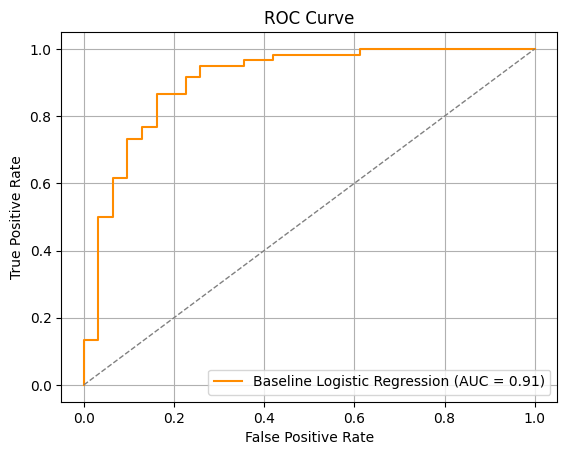

In [94]:
plot_roc_curve(y_test, y_test_pred_proba_base, label="Baseline Logistic Regression", color="darkorange")


In [95]:
def plot_confusion_matrix(y_true, y_pred, labels=[0, 1], normalize=None, title="Confusion Matrix", cmap="Blues"):
    """
    Plots a confusion matrix.
    
    Parameters:
    - y_true: True labels
    - y_pred: Predicted labels
    - labels: List of class labels (default [0, 1])
    - normalize: {‘true’, ‘pred’, ‘all’}, default=None. Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population.
    - title: Plot title
    - cmap: Color map
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap, values_format=".2f" if normalize else "d")
    plt.title(title)
    plt.grid(False)
    plt.show()

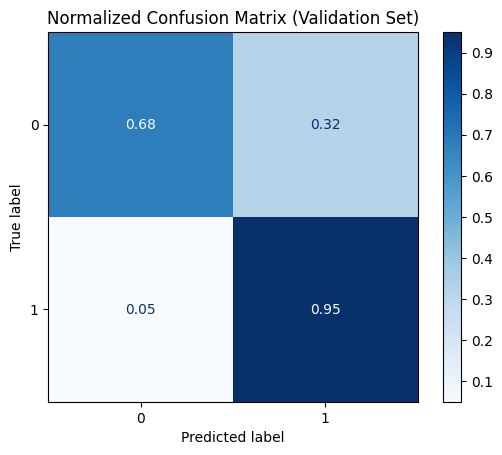

In [96]:
plot_confusion_matrix(y_test, y_test_pred_base, normalize="true", title="Normalized Confusion Matrix (Validation Set)", cmap="Blues")

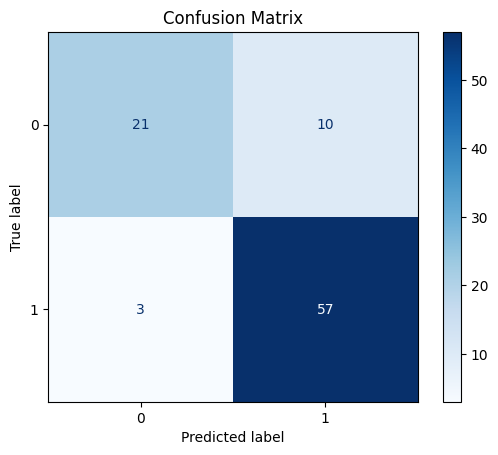

In [97]:
plot_confusion_matrix(y_test, y_test_pred_base,)

In [98]:
def print_classification_metrics(y_true, y_pred, y_proba=None, model_name="Model"):
    """
    Prints classification metrics for binary classification.
    
    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels
    - y_proba: Predicted probabilities (optional, for ROC AUC)
    - model_name: Name of the model (for display)
    """
    print(f"\n📊 Classification Report for {model_name}:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        print(f"ROC AUC:   {roc_auc_score(y_true, y_proba):.4f}")


In [99]:
print_classification_metrics(y_test, y_test_pred_base, y_test_pred_proba_base, model_name="Baseline Logistic Regression")


📊 Classification Report for Baseline Logistic Regression:
Accuracy:  0.8571
Precision: 0.8507
Recall:    0.9500
F1 Score:  0.8976
ROC AUC:   0.9059


In [100]:
import shap

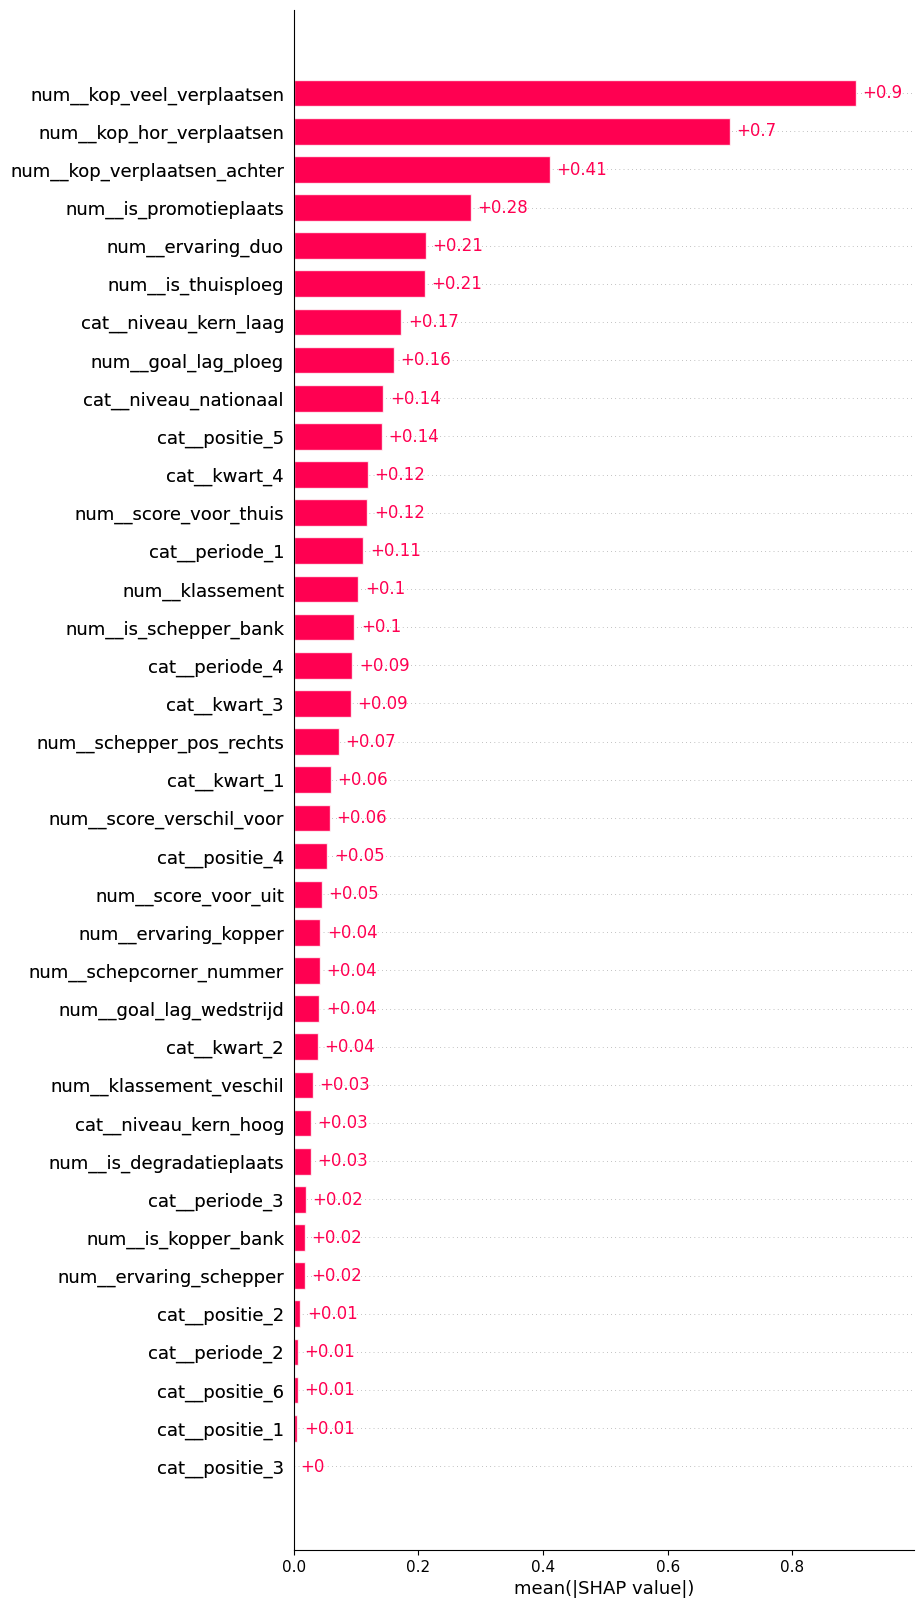

In [101]:
# Make sure you use the encoded feature names
X_test_df = pd.DataFrame(X_test_transformed, columns=encoded_feature_names)

# Create SHAP explainer for logistic regression
explainer_base = shap.Explainer(baseline_model, X_test_df)

# Compute SHAP values
shap_values = explainer_base(X_test_df)

# Plot global SHAP feature importance
shap.plots.bar(shap_values.abs.mean(0), max_display= len(encoded_feature_names))

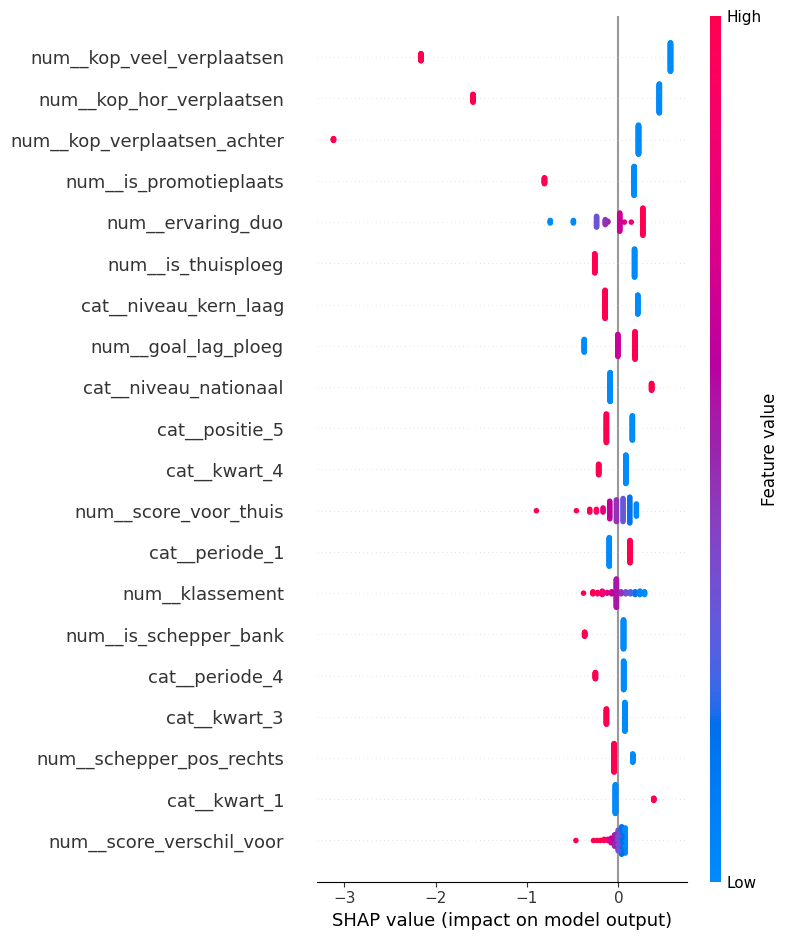

In [102]:
shap.summary_plot(shap_values, X_test_transformed)

### Random Forest

In [103]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

X_test_transformed_rf = rf_pipeline.named_steps["preprocessor"].transform(X_test)

In [104]:
# Define hyperparameter grid
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2"]
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_val, y_train_val)
best_rf_pipeline = random_search.best_estimator_
best_rf_model = best_rf_pipeline.named_steps["classifier"]

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [105]:
# Predict probabilities and labels
y_rf_proba = best_rf_pipeline.predict_proba(X_test)[:, 1]
y_rf_preds = best_rf_pipeline.predict(X_test)

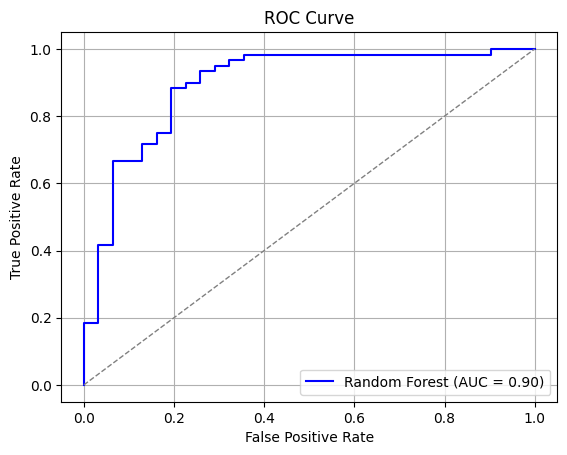

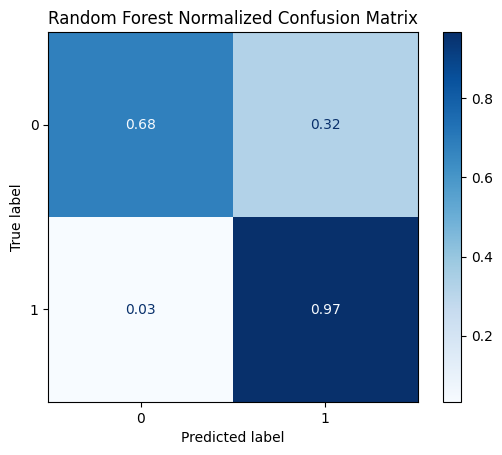

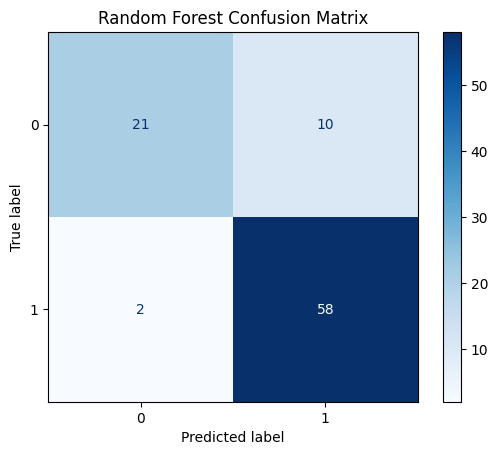


📊 Classification Report for Random Forest:
Accuracy:  0.8681
Precision: 0.8529
Recall:    0.9667
F1 Score:  0.9062
ROC AUC:   0.8952


In [106]:
# Evaluation
plot_roc_curve(y_test, y_rf_proba, label="Random Forest")
plot_confusion_matrix(y_test, y_rf_preds, normalize="true", title="Random Forest Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_rf_preds, title = "Random Forest Confusion Matrix")
print_classification_metrics(y_test, y_rf_preds, y_rf_proba, model_name="Random Forest")


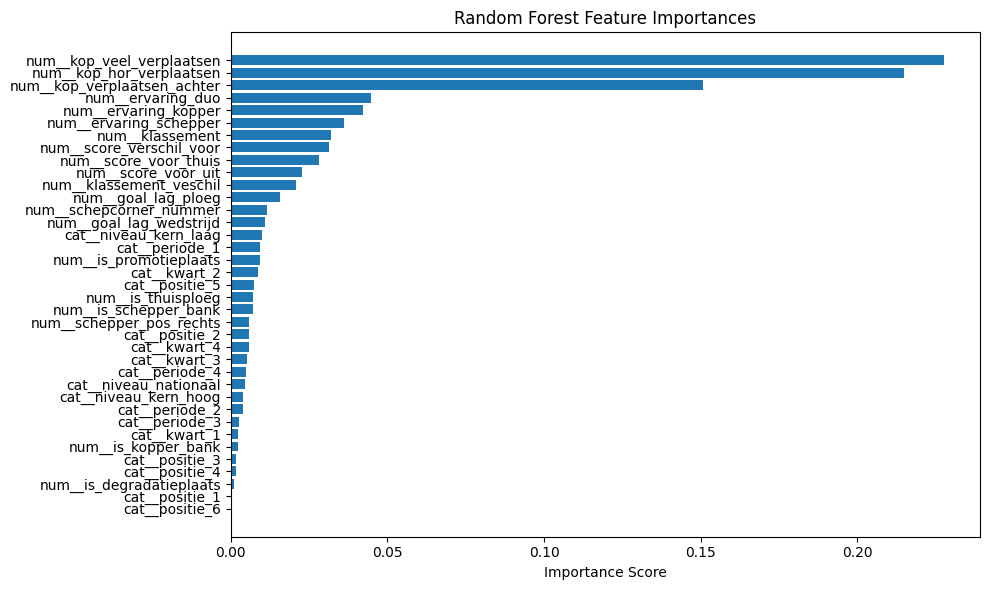

In [107]:
# Ensure your feature importances and names match in length
importances = best_rf_model.feature_importances_
feature_names = encoded_feature_names  # Make sure this matches the feature order in training

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.barh(range(len(sorted_importances)), sorted_importances[::-1], align="center")
plt.yticks(range(len(sorted_importances)), sorted_feature_names[::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [108]:
type(best_rf_model)

sklearn.ensemble._forest.RandomForestClassifier

In [110]:
X_test_rf_df.head()

,num__ervaring_duo,num__ervaring_kopper,num__ervaring_schepper,num__goal_lag_ploeg,num__goal_lag_wedstrijd,num__is_degradatieplaats,num__is_kopper_bank,num__is_promotieplaats,num__is_schepper_bank,num__is_thuisploeg,...,cat__positie_1,cat__positie_2,cat__positie_3,cat__positie_4,cat__positie_5,cat__positie_6,cat__periode_1,cat__periode_2,cat__periode_3,cat__periode_4
0,0.0,1.0,0.75,1.000000,0.661692,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.75,1.000000,1.000000,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.5,1.0,0.50,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.5,0.5,0.75,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.5,0.5,0.50,0.661692,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [111]:
best_rf_model

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [76]:
# Make sure you use the encoded feature names
X_test_rf_df = pd.DataFrame(X_test_transformed_rf, columns=encoded_feature_names)

# Create SHAP explainer for logistic regression
explainer_rf = shap.TreeExplainer(best_rf_model, X_test_rf_df)

# Compute SHAP values
shap_values_rf = explainer_rf(X_test_rf_df)

# Plot global SHAP feature importance
shap.plots.bar(shap_values_rf.abs.mean(0), max_display= len(encoded_feature_names))

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.268222, while the model output was 0.271198. If this difference is acceptable you can set check_additivity=False to disable this check.

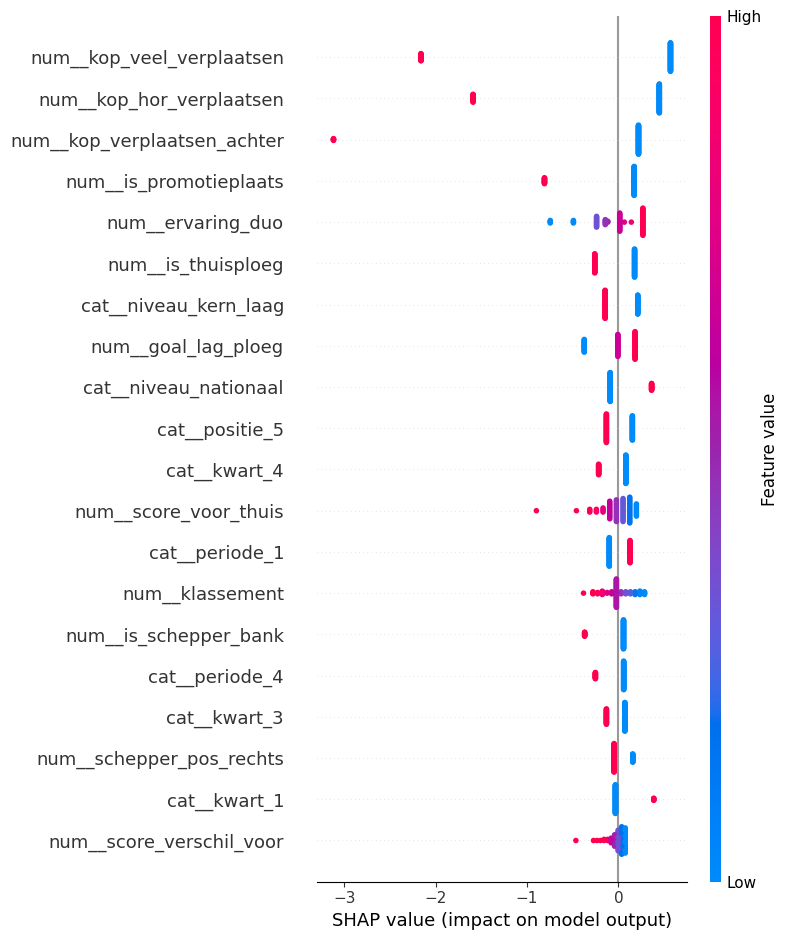

In [40]:
shap.summary_plot(shap_values_rf, X_test_transformed_rf)

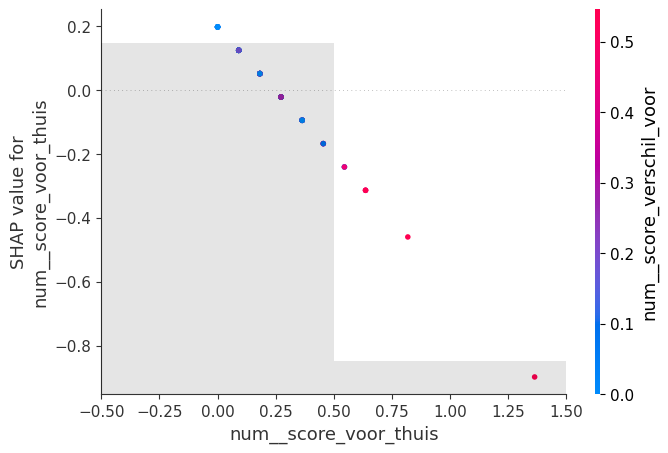

In [44]:
# dependence plot, inspect impact of a single feature on the model output
shap.plots.scatter(shap_values_rf[:, "num__score_voor_thuis"], color=shap_values_rf)

In [47]:
X_test_transformed_rf

array([[0.  , 1.  , 0.75, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.75, ..., 1.  , 0.  , 0.  ],
       [0.5 , 1.  , 0.5 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.75, 0.75, 0.75, ..., 0.  , 0.  , 0.  ],
       [0.75, 0.75, 0.75, ..., 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , ..., 0.  , 0.  , 1.  ]])

<BarContainer object of 37 artists>

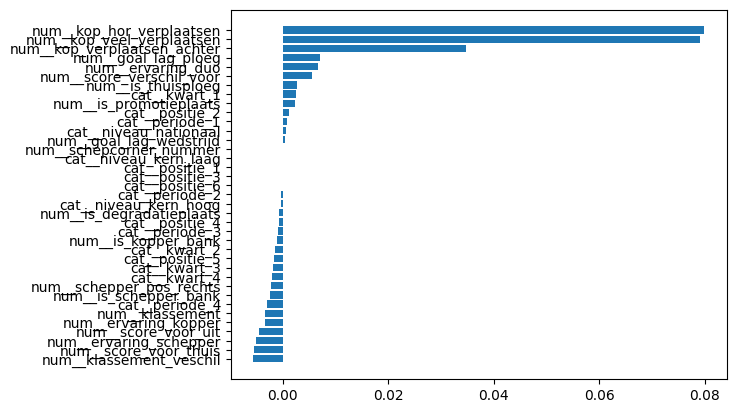

In [52]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_rf_model, X_test_transformed_rf, y_test, scoring = 'roc_auc', n_repeats=20)
sorted_idx2 = perm_importance.importances_mean.argsort()
plt.barh(X_test_rf_df.columns[sorted_idx2], perm_importance.importances_mean[sorted_idx2])

### Model zonder schepkwaliteit indicatoren

In [69]:
### 
X_zonder = X_train_val.drop(columns=["kop_hor_verplaatsen", "kop_veel_verplaatsen", "kop_verplaatsen_achter"])
X_test_zonder = X_test.drop(columns=["kop_hor_verplaatsen", "kop_veel_verplaatsen", "kop_verplaatsen_achter"])
to_remove = ["kop_hor_verplaatsen", "kop_veel_verplaatsen", "kop_verplaatsen_achter"]
num_cols = [col for col in num_cols if col not in to_remove]


In [ ]:
# Define transformers
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Combine into column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [64]:
# Separate features and target
X = basetable[num_cols_zonder + cat_cols]
y = basetable["goal"]

# Apply the preprocessing
X_transformed_zonder = preprocessor.fit_transform(X)

# get feature names after transformation
encoded_feature_names_zonder = preprocessor.get_feature_names_out()

In [65]:
zonder_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

X_test_transformed_zonder = zonder_pipeline.named_steps["preprocessor"].transform(X_test)

In [68]:
# Define hyperparameter grid
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2"]
}

random_search = RandomizedSearchCV(
    zonder_pipeline,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_zonder, y_train_val)
best_zonder_pipeline = random_search.best_estimator_
best_zonder_model = best_zonder_pipeline.named_steps["classifier"]

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [71]:
# Predict probabilities and labels
y_zonder_proba = best_zonder_pipeline.predict_proba(X_test_zonder)[:, 1]
y_zonder_preds = best_zonder_pipeline.predict(X_test_zonder)

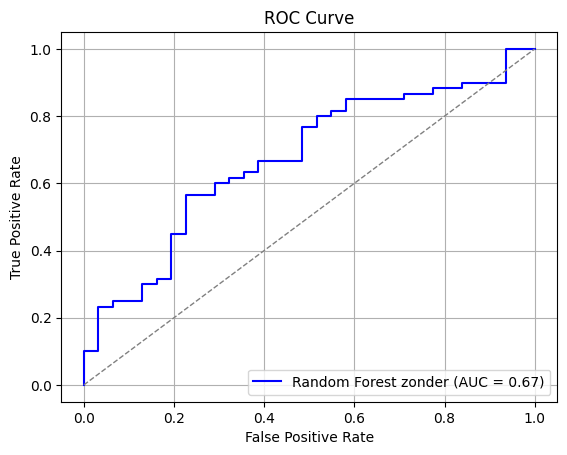

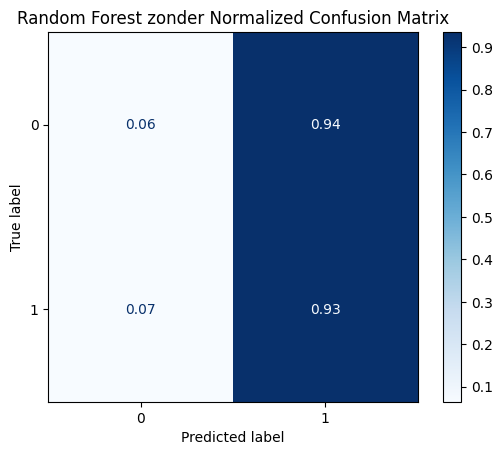

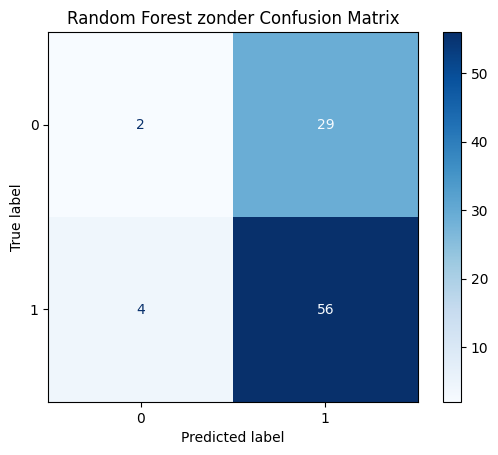


📊 Classification Report for Random Forest zonder:
Accuracy:  0.6374
Precision: 0.6588
Recall:    0.9333
F1 Score:  0.7724
ROC AUC:   0.6731


In [73]:
# Evaluation
plot_roc_curve(y_test, y_zonder_proba, label="Random Forest zonder")
plot_confusion_matrix(y_test, y_zonder_preds, normalize="true", title="Random Forest zonder Normalized Confusion Matrix")
plot_confusion_matrix(y_test, y_zonder_preds, title = "Random Forest zonder Confusion Matrix")
print_classification_metrics(y_test, y_zonder_preds, y_zonder_proba, model_name="Random Forest zonder")


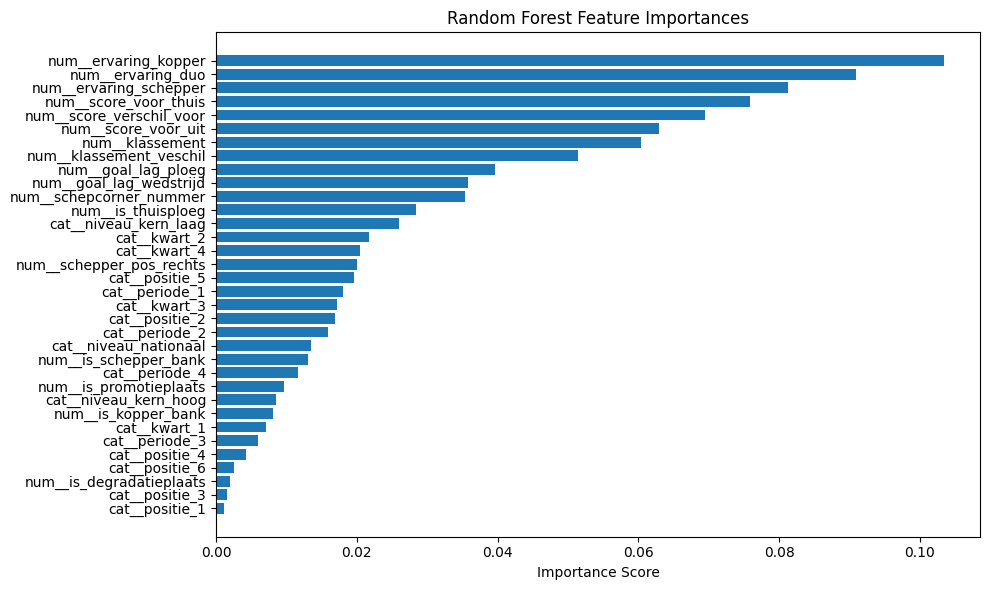

In [113]:
importances = best_zonder_model.feature_importances_
feature_names = encoded_feature_names_zonder  # Make sure this matches the feature order in training

# Sort features by importance
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.barh(range(len(sorted_importances)), sorted_importances[::-1], align="center")
plt.yticks(range(len(sorted_importances)), sorted_feature_names[::-1])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

<BarContainer object of 34 artists>

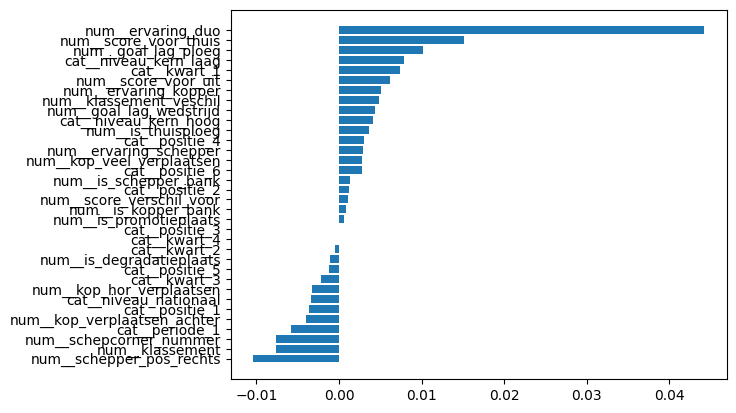

In [114]:
perm_importance_zonder = permutation_importance(best_zonder_model, X_test_transformed_zonder, y_test, scoring = 'roc_auc', n_repeats=20)
sorted_idx2 = perm_importance_zonder.importances_mean.argsort()
plt.barh(X_test_rf_df.columns[sorted_idx2], perm_importance_zonder.importances_mean[sorted_idx2])